<center><h1> The Evaluation of the Chatbot *Jarvis*</h1></center>
<br>
<center>Yujia Zhang<br>
STAT/CS 287 Data Science I, Fall 2017<br>
Instructor: James Bagrow<br>
*College of Engineering and Mathematical Sciences, UVM*</center>

In [1]:
# Import
import sys, os
import sqlite3
import pickle
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

In [2]:
# Function
def findMisPredicted(predicted):
    """Find which text was wrongly predicted by current model.
    show that text, predicted lable and correct lable.
    """
    for i in range(len(lable)):
        if predicted[i] != lable[i]:
            for row in c.execute("SELECT * from training_data"):
                if row[0] == i:
                    print("'{}' was labled as '{}' but was predicted as '{}'.".format(row[1],lable[i],predicted[i]))

---
# Introduction
Jarvis is online chatbot designed and trained on Slack, an online communication platform. Jarvis was trained by a corpus consisting of many documents for each label. With training inputs were stored in a database, Jarvis will work as a text classifier: users send it a chat message and it will use a text classification algorithm to decide the class of the documents. <br>
<center>**Example of Jarvis in Training Mode**
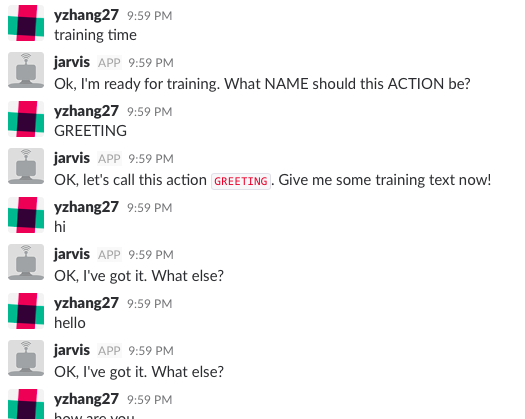</center>
<br>
<center>**Example of Jarvis in Testing Mode**
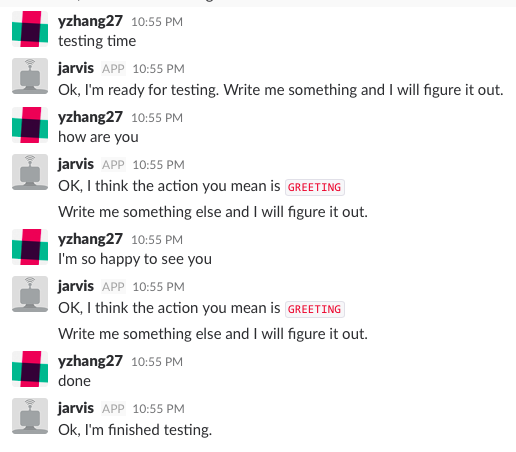</center>
<br>
In this report, two scikit-learn classifers will be evaluated about based on their performance and accuracy.

---
# Evaluation
Two trained classifiers were persisted using Python’s built-in persistence model, namely pickle for future use without retraining. In this evaluation, two classifiers will be loaded separately, then make predictions using training database, and compare the predicted label with the original label to determine the accuracy.

In [3]:
# Connect to the database that contains all training text and lables
db_file = "jarvis.db"
conn = sqlite3.connect(db_file)
c = conn.cursor()

# Extract training text and lables from database
text = []
lable = []
for row in c.execute("SELECT * from training_data"):
    text.append(row[1])
    lable.append(row[2])

## *Multinomial Naïve Bayes* Classifer

In [8]:
# Load trained NB model
if os.path.getsize('jarvis_brain.pkl') > 0: 
    model_NB = pickle.load(open('jarvis_brain.pkl', 'rb'))

# Predict ACTION using training text by cross-validation givin current model
predicted = cross_val_predict(model_NB, text, lable, cv=5)
# Show those text which predicted result does not match with the original lable
findMisPredicted(predicted)

# Calculate the accuracy of this prediction
accuracy = metrics.accuracy_score(lable, predicted)
print()
print("The estimated NB classification accuracy is {0:.4f}.".format(accuracy))

'long time no see' was labled as 'GREETING' but was predicted as 'WEATHER'.
'tell me a joke' was labled as 'JOKE' but was predicted as 'GREETING'.
'find the best joke and tell me' was labled as 'JOKE' but was predicted as 'WEATHER'.

The estimated NB classification accuracy is 0.9286.


I measured this accuracy by cross-validation using training text. Since we have five classes, we used a k-fold (k=5) cross validations here, which means the training text set is split into 5 smaller sets. For each of the 5 "folds", the model is trained using 4 of the folds as training data. Then the model is validated on the remaining fold. The overall accuracy is computed by repeating k-fold cross-validation and averaging the values in each loop. 

In [5]:
accuracy_metric = metrics.classification_report(lable, predicted)
print(accuracy_metric)

             precision    recall  f1-score   support

   GREETING       0.90      0.90      0.90        10
       JOKE       1.00      0.75      0.86         8
      PIZZA       1.00      1.00      1.00         8
       TIME       1.00      1.00      1.00         8
    WEATHER       0.80      1.00      0.89         8

avg / total       0.94      0.93      0.93        42



A more detailed analysis of computed accuracy using cross-validation can be found in the metric above. 

For each label, the "precision" column is calculated by dividing the number of correct prediction by the total number of returned results. "recall" which is also known as sensitivity is calculated by dividing the number of correct prediction by the total number of prediction. "recall" is the relatively more important score in accuracy measuring and determining how good our model is. "f1-score" which is also known as "f-measure" shows the average of "precision" and "recall" of each label.

From the predicting results that we showed in the previous cell, two texts labeled "JOKE" were mispredicted and one text labeled "GREETING" was mispredicted. So it makes sense that "JOKE" has the lowest recall score and "GREETING" has the second lowest score. Two texts were mispredicted as "WEATHER" and one text was mispredicted as "GREETING" which is also corresponded with the fact that "WEATHER" has the lowest precision and "GREETING" has the second lowest precision.

From my personal perspective, I think those texts containing "find", "see" and "tell" are easy to be mispredicted, because multiple labels can be related to those keywords. 

## *Support Vector Machines (SVM)* classifier

In [10]:
# Load trained SVM model
if os.path.getsize('jarvis_brain_svm.pkl') > 0: 
    model_SVM = pickle.load(open('jarvis_brain_svm.pkl', 'rb'))

# Predict ACTION using training text by cross-validation givin current model
predicted_svm = cross_val_predict(model_SVM, text, lable, cv=5)

# Show those text which predicted result does not match with the original lable
findMisPredicted(predicted_svm)

# Calculate the accuracy of this prediction
accuracy_svm = metrics.accuracy_score(lable, predicted_svm)
print()
print("The estimated SVM classification accuracy is {0:.4f}.".format(accuracy_svm))

'long time no see' was labled as 'GREETING' but was predicted as 'WEATHER'.

The estimated SVM classification accuracy is 0.9762.


In [11]:
accuracy_metric_svm = metrics.classification_report(lable, predicted_svm)
print(accuracy_metric_svm)

             precision    recall  f1-score   support

   GREETING       1.00      0.90      0.95        10
       JOKE       1.00      1.00      1.00         8
      PIZZA       1.00      1.00      1.00         8
       TIME       1.00      1.00      1.00         8
    WEATHER       0.89      1.00      0.94         8

avg / total       0.98      0.98      0.98        42



In the SVM classifier, each data item is plotted as a point in 2-dimensional space with the value of each feature being the value of a particular coordinate. Then the classification is performed by finding the hyperplane that differentiates the classes well. Support Vectors are simply the coordinates of individual observation. It is a frontier which best segregates the classes. Even though text data are studied here, those data can be transformed into the numerical form based on their labels. So SVM classifier can still perform well here.

The performance of the SVM classifier heavily depends on the support vectors. There are multiple options and parameters set for the support vectors. The linear support vectors were used here because it's simple to use and understand. Based on the accuracy matrix above, this SVM classifier works very well with this dataset. The accuracy of its prediction is 0.9762, slightly higher than the Naive Bayes classifier. However, the support vectors are not consistent, so sometimes, the accuracy may get lower. 

---
# Discussion

Both classifiers have their pros and cons. Naive Bayes classifier uses "bag of words" concept, and make the prediction based on the calculated the posterior probability. It is easy to understand and works well with categorical data. But if there was not observed in training data set, then the model will assign a 0 probability and will be unable to make a prediction about the label. Also "independent predictors" assumption of the Naive Bayes is almost impossible to be true in the real life. 

On the other hand, SVM classifier makes predictions based on the support vectors that segmented the original data. It works well with data that has clear margins and is more flexible since there are multiple support vectors available (linear, polynomial, and etc.). But it does not perform very well with data with more noise, which could be the reason for inconsistent accuracy in this Jarvis training data.

I think phasing same meaning in different ways is very helpful with recognizing natural language. One benefits of this are it can help with filtering out those less important words which appear in most of the classes and make those "real" keywords weighted more in prediction. Also increasing the number of input can be helpful too. With more input, the variation between each class can be bigger and the variation within each class will be smaller. So the prediction would be more accurate.

To increase the computed accuracy of prediction, having the relatively same number of input for each class is helpful too.